# Heart Disease Classifier

![photo](data/heart.jpg)

### Import Libraries

In [1]:
import os
from zipfile import ZipFile
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import tensorflow as tf

from sklearn.model_selection import train_test_split

DATA_PATH = os.path.join('data', 'heart_disease_dataset.zip')
EXTRACT_PATH = os.path.join('data')

### Data Exploring

In [2]:
# Data from https://www.kaggle.com/andrewmvd/heart-failure-clinical-data
def unzip_file(data_path=DATA_PATH, extract_path=EXTRACT_PATH):
    if not os.path.isfile(data_path):
        return "File does not exist"
    with ZipFile(data_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        return 'File extracted'

In [3]:
unzip_file()

'File extracted'

In [4]:
heart_disease_df = pd.read_csv(os.path.join('data', 'heart_failure_clinical_records_dataset.csv'))
heart_disease_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


* Sex: Gender of patient Male = 1, Female =0
* Age: Age of patient
* Diabetes: 0 = No, 1 = Yes
* Anaemia: 0 = No, 1 = Yes
* High_blood_pressure: 0 = No, 1 = Yes
* Smoking: 0 = No, 1 = Yes
* DEATH_EVENT: 0 = No, 1 = Yes

In [5]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [6]:
heart_disease_df[['age', 'platelets']] = heart_disease_df[['age', 'platelets']].astype(np.int64)

In [7]:
heart_disease_df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.829431,0.431438,581.839465,0.418060,38.083612,0.351171,263358.026756,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894997,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


### Data Analyst

#### Feature importances

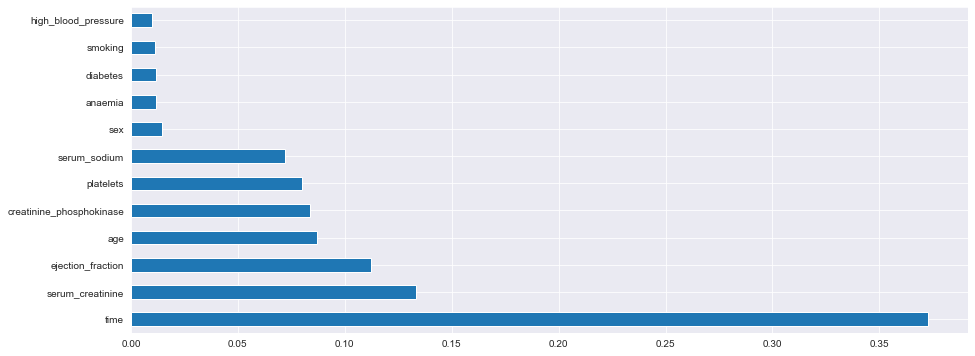

In [8]:
plt.figure(figsize=(15,6))
sns.set_style("darkgrid")

X = heart_disease_df.drop('DEATH_EVENT', axis=1)
y = heart_disease_df['DEATH_EVENT']

model = RandomForestClassifier(random_state=69)
model.fit(X,y)

importance = model.feature_importances_
importance_series = pd.Series(importance, index=X.columns)
importance_series.nlargest(12).plot(kind='barh')

plt.show()

#### Features Correlation 

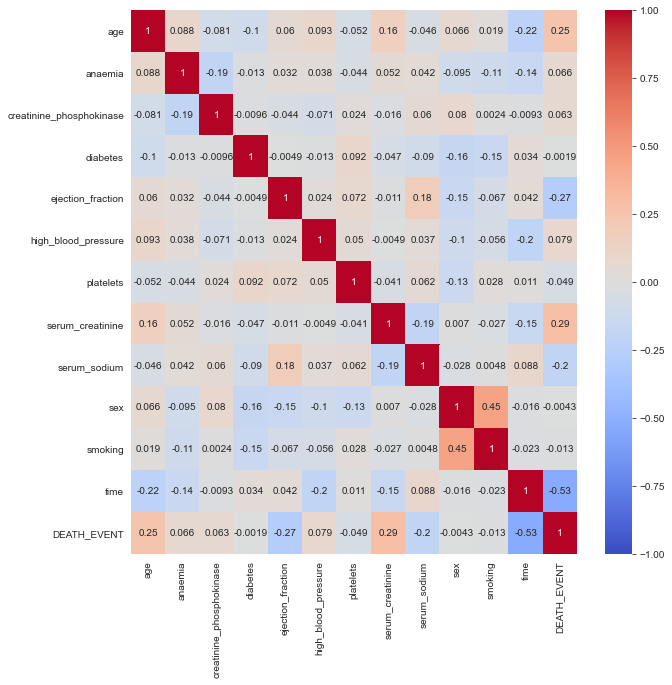

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(heart_disease_df.corr(), vmin=-1, cmap='coolwarm', annot=True);

### Modeling

#### Datasets preparing

In [10]:
features = ['time','ejection_fraction', 'serum_creatinine']
X = heart_disease_df[features]
y = heart_disease_df["DEATH_EVENT"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=69)

In [11]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [12]:
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}

In [13]:
def results(y_test,model, model_name=None):
    accuracy = round(accuracy_score(y_test, model),4)
    precision = round(precision_score(y_test,model),4)
    recall = round(recall_score(y_test,model),4)
    f1 = round(f1_score(y_test,model),4)
    
    if model_name:
        accuracy_dict[model_name] = accuracy
        precision_dict[model_name] = precision
        recall_dict[model_name] = recall
        f1_dict[model_name] = f1
    
    print(confusion_matrix(y_test, model))
    print(f"accuracy: {accuracy}")
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"f1_score: {f1}")

#### Logistic Regression

In [14]:
log_reg = LogisticRegression(solver='lbfgs')
score = cross_val_score(log_reg, X_train_sc, y_train, cv=5)
score.mean()

0.8453014184397162

In [15]:
log_reg.fit(X_train_sc,y_train)
log_cross_pred = cross_val_predict(log_reg, X_test_sc, y_test, cv=5)

results(y_test,log_cross_pred, "Logistic Regression")

[[36  4]
 [ 8 12]]
accuracy: 0.8
precision: 0.75
recall: 0.6
f1_score: 0.6667


#### Suport Vector Classification

In [16]:
svc_param_grid =[
    {'C':np.linspace(0.01,1.0, num=100), 'gamma':np.arange(1,10), 'kernel':['rbf','sigmoid']}
]
svc = SVC()
svc_grid_search= GridSearchCV(svc, svc_param_grid, cv=5, scoring='accuracy')
svc_grid_search.fit(X_train_sc, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
                          'gamma': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'kernel': ['rbf', 'sigmoid']}],
             scoring='accuracy')

In [17]:
svc_params = svc_grid_search.best_params_
svc_params

{'C': 0.6900000000000001, 'gamma': 1, 'kernel': 'rbf'}

In [18]:
svc_clf = SVC(kernel=svc_params['kernel'], gamma=svc_params['gamma'], C=svc_params['C'])
svc_score = cross_val_score(svc_clf, X_train_sc, y_train, cv=5)
svc_score.mean()

0.8579787234042554

In [19]:
svc_clf.fit(X_train_sc,y_train)
svc_clf_cross_pred = cross_val_predict(svc_clf, X_test_sc, y_test, cv=5)

results(y_test,svc_clf_cross_pred, "SVC")

[[36  4]
 [ 9 11]]
accuracy: 0.7833
precision: 0.7333
recall: 0.55
f1_score: 0.6286


#### K-Nearest Neighbors Classifier

In [20]:
knc_param_grid =[
    {'n_neighbors':np.arange(3,10), 'leaf_size':np.arange(10,100,10)}
]
knc = KNeighborsClassifier()
knc_grid_search= GridSearchCV(knc, knc_param_grid, cv=5, scoring='accuracy')
knc_grid_search.fit(X_train_sc, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'leaf_size': array([10, 20, 30, 40, 50, 60, 70, 80, 90]),
                          'n_neighbors': array([3, 4, 5, 6, 7, 8, 9])}],
             scoring='accuracy')

In [21]:
knc_params = knc_grid_search.best_params_
knc_params

{'leaf_size': 10, 'n_neighbors': 3}

In [22]:
knc_clf = KNeighborsClassifier(leaf_size=knc_params['leaf_size'], n_neighbors=knc_params['n_neighbors'])
knc_score = cross_val_score(knc_clf, X_train_sc, y_train, cv=5)
knc_score.mean()

0.8535460992907801

In [23]:
knc_clf.fit(X_train_sc,y_train)
knc_clf_cross_pred = cross_val_predict(knc_clf, X_test_sc, y_test, cv=5)

results(y_test,knc_clf_cross_pred, "KNeighborsClassifier")

[[34  6]
 [ 9 11]]
accuracy: 0.75
precision: 0.6471
recall: 0.55
f1_score: 0.5946


#### Decision Tree Classifier

In [24]:
tree_param_grid =[
    {'max_depth':np.arange(1,10), 'min_samples_split':np.arange(2,10)}
]
tree = DecisionTreeClassifier()
tree_grid_search= GridSearchCV(tree, tree_param_grid, cv=5)
tree_grid_search.fit(X_train_sc, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])}])

In [25]:
tree_params = tree_grid_search.best_params_
tree_params

{'max_depth': 3, 'min_samples_split': 2}

In [26]:
tree_clf = DecisionTreeClassifier(
    max_depth=tree_params['max_depth'], min_samples_split=tree_params['min_samples_split'], criterion='entropy')
tree_score = cross_val_score(tree_clf, X_train_sc, y_train, cv=5)
tree_score.mean()

0.8411347517730496

In [27]:
tree_clf.fit(X_train_sc,y_train)
tree_clf_cross_pred = cross_val_predict(tree_clf, X_test_sc, y_test, cv=5)

results(y_test, tree_clf_cross_pred, "DecisionTreeClassifier")

[[33  7]
 [ 7 13]]
accuracy: 0.7667
precision: 0.65
recall: 0.65
f1_score: 0.65


#### Bagging Classifier

In [28]:
bag_param_grid =[
    {'n_estimators':np.arange(100,500,100), 'max_samples':np.arange(50,200,50)}
]
bag = BaggingClassifier()
bag_grid_search= GridSearchCV(bag, bag_param_grid, cv=5)
bag_grid_search.fit(X_train_sc, y_train)

GridSearchCV(cv=5, estimator=BaggingClassifier(),
             param_grid=[{'max_samples': array([ 50, 100, 150]),
                          'n_estimators': array([100, 200, 300, 400])}])

In [29]:
bag_params = bag_grid_search.best_params_
bag_params

{'max_samples': 50, 'n_estimators': 100}

In [30]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=300,
    max_samples=50, bootstrap=True, n_jobs=-1,
    random_state=69)
bag_score = cross_val_score(bag_clf, X_train_sc, y_train, cv=5)
bag_score.mean()

0.861968085106383

In [31]:
bag_clf.fit(X_train_sc, y_train)
bag_clf_pred = bag_clf.predict(X_test_sc)
results(y_test, bag_clf_pred, "BaggingClassifier")

[[38  2]
 [ 8 12]]
accuracy: 0.8333
precision: 0.8571
recall: 0.6
f1_score: 0.7059


#### Random Forest Classifier

In [32]:
forest_param_grid =[
    {'n_estimators':np.arange(100,500,100), 'max_leaf_nodes':np.arange(10,100,10)}
]
forest = RandomForestClassifier()
forest_grid_search= GridSearchCV(forest, forest_param_grid, cv=5)
forest_grid_search.fit(X_train_sc, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_leaf_nodes': array([10, 20, 30, 40, 50, 60, 70, 80, 90]),
                          'n_estimators': array([100, 200, 300, 400])}])

In [33]:
forest_params = forest_grid_search.best_params_
forest_params

{'max_leaf_nodes': 50, 'n_estimators': 300}

In [34]:
rnd_clf = RandomForestClassifier(
    n_estimators=forest_params['n_estimators'], max_leaf_nodes=forest_params['max_leaf_nodes'],
    n_jobs=-1, random_state=69
)
rnd_score = cross_val_score(rnd_clf, X_train_sc, y_train, cv=5)
rnd_score.mean()

0.8659574468085106

In [35]:
rnd_clf.fit(X_train_sc, y_train)
rnd_clf_pred = rnd_clf.predict(X_test_sc)
results(y_test, rnd_clf_pred, "RandomForestClassifier")

[[37  3]
 [ 7 13]]
accuracy: 0.8333
precision: 0.8125
recall: 0.65
f1_score: 0.7222


#### Ada Boost Classifier

In [36]:
ada_param_grid =[
    {'n_estimators':np.arange(100,500,100), 'learning_rate':np.arange(0.5,10.5,0.5)}
]
ada_tree = DecisionTreeClassifier(max_depth=tree_params['max_depth'], min_samples_split=tree_params['min_samples_split'])
ada = AdaBoostClassifier(ada_tree, algorithm="SAMME.R")

ada_grid_search= GridSearchCV(ada, ada_param_grid, cv=5)
ada_grid_search.fit(X_train_sc, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3)),
             param_grid=[{'learning_rate': array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
                          'n_estimators': array([100, 200, 300, 400])}])

In [37]:
ada_params = ada_grid_search.best_params_
ada_params

{'learning_rate': 1.0, 'n_estimators': 100}

In [38]:
ada_clf = AdaBoostClassifier(
    ada_tree, algorithm="SAMME.R",
    n_estimators=ada_params['n_estimators'], learning_rate=ada_params['learning_rate']
)
ada_score = cross_val_score(ada_clf, X_train_sc, y_train, cv=5)
ada_score.mean()

0.8411347517730496

In [39]:
ada_clf.fit(X_train_sc, y_train)
ada_clf_pred = ada_clf.predict(X_test_sc)
results(y_test, ada_clf_pred, "AdaBoostClassifier")

[[37  3]
 [ 8 12]]
accuracy: 0.8167
precision: 0.8
recall: 0.6
f1_score: 0.6857


#### XGB Classifier

In [40]:
xgb_clf = XGBClassifier(max_depth=1)
xgb_score = cross_val_score(xgb_clf, X_train_sc, y_train, cv=5)
xgb_score.mean()

[10:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows 10\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:20:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

0.8660460992907801

In [41]:
xgb_clf.fit(X_train_sc, y_train)
xgb_clf_pred = xgb_clf.predict(X_test_sc)
results(y_test, xgb_clf_pred, "XGBoostClassifier")

[10:20:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[37  3]
 [ 8 12]]
accuracy: 0.8167
precision: 0.8
recall: 0.6
f1_score: 0.6857


#### Cat Boost Classifier

In [42]:
cb_clf = CatBoostClassifier()
cb_score = cross_val_score(cb_clf, X_train_sc, y_train, cv=5)
cb_score.mean()

Learning rate set to 0.005081
0:	learn: 0.6891875	total: 54.8ms	remaining: 54.7s
1:	learn: 0.6849053	total: 56ms	remaining: 27.9s
2:	learn: 0.6803718	total: 56.9ms	remaining: 18.9s
3:	learn: 0.6764327	total: 57.9ms	remaining: 14.4s
4:	learn: 0.6722120	total: 59ms	remaining: 11.7s
5:	learn: 0.6686318	total: 59.9ms	remaining: 9.93s
6:	learn: 0.6648665	total: 61ms	remaining: 8.65s
7:	learn: 0.6611586	total: 62ms	remaining: 7.68s
8:	learn: 0.6577740	total: 63.1ms	remaining: 6.95s
9:	learn: 0.6535512	total: 64.2ms	remaining: 6.35s
10:	learn: 0.6496393	total: 65.1ms	remaining: 5.85s
11:	learn: 0.6458199	total: 66.4ms	remaining: 5.47s
12:	learn: 0.6425851	total: 67.5ms	remaining: 5.13s
13:	learn: 0.6391705	total: 68.7ms	remaining: 4.84s
14:	learn: 0.6352898	total: 70ms	remaining: 4.59s
15:	learn: 0.6316800	total: 71ms	remaining: 4.37s
16:	learn: 0.6287744	total: 71.9ms	remaining: 4.16s
17:	learn: 0.6247082	total: 72.9ms	remaining: 3.98s
18:	learn: 0.6219322	total: 74ms	remaining: 3.82s
19:	le

206:	learn: 0.3356312	total: 283ms	remaining: 1.08s
207:	learn: 0.3349805	total: 284ms	remaining: 1.08s
208:	learn: 0.3343253	total: 285ms	remaining: 1.08s
209:	learn: 0.3336934	total: 287ms	remaining: 1.08s
210:	learn: 0.3330873	total: 288ms	remaining: 1.08s
211:	learn: 0.3326569	total: 289ms	remaining: 1.07s
212:	learn: 0.3321176	total: 290ms	remaining: 1.07s
213:	learn: 0.3315225	total: 291ms	remaining: 1.07s
214:	learn: 0.3311436	total: 292ms	remaining: 1.07s
215:	learn: 0.3306169	total: 293ms	remaining: 1.06s
216:	learn: 0.3298950	total: 294ms	remaining: 1.06s
217:	learn: 0.3291185	total: 296ms	remaining: 1.06s
218:	learn: 0.3285467	total: 297ms	remaining: 1.06s
219:	learn: 0.3277146	total: 298ms	remaining: 1.06s
220:	learn: 0.3270727	total: 299ms	remaining: 1.05s
221:	learn: 0.3263343	total: 301ms	remaining: 1.05s
222:	learn: 0.3256684	total: 302ms	remaining: 1.05s
223:	learn: 0.3251965	total: 303ms	remaining: 1.05s
224:	learn: 0.3244540	total: 304ms	remaining: 1.05s
225:	learn: 

379:	learn: 0.2647922	total: 483ms	remaining: 789ms
380:	learn: 0.2646713	total: 484ms	remaining: 787ms
381:	learn: 0.2645277	total: 486ms	remaining: 786ms
382:	learn: 0.2643147	total: 487ms	remaining: 784ms
383:	learn: 0.2640829	total: 488ms	remaining: 783ms
384:	learn: 0.2637894	total: 489ms	remaining: 782ms
385:	learn: 0.2633821	total: 491ms	remaining: 780ms
386:	learn: 0.2631797	total: 492ms	remaining: 779ms
387:	learn: 0.2629330	total: 494ms	remaining: 779ms
388:	learn: 0.2624940	total: 495ms	remaining: 777ms
389:	learn: 0.2622735	total: 496ms	remaining: 776ms
390:	learn: 0.2621315	total: 498ms	remaining: 775ms
391:	learn: 0.2616351	total: 499ms	remaining: 774ms
392:	learn: 0.2613300	total: 500ms	remaining: 773ms
393:	learn: 0.2611706	total: 502ms	remaining: 772ms
394:	learn: 0.2609428	total: 503ms	remaining: 770ms
395:	learn: 0.2606990	total: 504ms	remaining: 769ms
396:	learn: 0.2602848	total: 505ms	remaining: 768ms
397:	learn: 0.2600912	total: 507ms	remaining: 767ms
398:	learn: 

558:	learn: 0.2262805	total: 690ms	remaining: 544ms
559:	learn: 0.2260902	total: 691ms	remaining: 543ms
560:	learn: 0.2258813	total: 692ms	remaining: 542ms
561:	learn: 0.2255969	total: 693ms	remaining: 540ms
562:	learn: 0.2252696	total: 694ms	remaining: 539ms
563:	learn: 0.2251493	total: 695ms	remaining: 538ms
564:	learn: 0.2248290	total: 697ms	remaining: 536ms
565:	learn: 0.2246991	total: 698ms	remaining: 535ms
566:	learn: 0.2245360	total: 699ms	remaining: 534ms
567:	learn: 0.2244992	total: 699ms	remaining: 532ms
568:	learn: 0.2242967	total: 700ms	remaining: 531ms
569:	learn: 0.2241343	total: 702ms	remaining: 529ms
570:	learn: 0.2238779	total: 703ms	remaining: 528ms
571:	learn: 0.2237558	total: 704ms	remaining: 527ms
572:	learn: 0.2234829	total: 705ms	remaining: 525ms
573:	learn: 0.2232327	total: 706ms	remaining: 524ms
574:	learn: 0.2230976	total: 707ms	remaining: 523ms
575:	learn: 0.2228054	total: 708ms	remaining: 521ms
576:	learn: 0.2226751	total: 709ms	remaining: 520ms
577:	learn: 

745:	learn: 0.1975051	total: 903ms	remaining: 307ms
746:	learn: 0.1974196	total: 904ms	remaining: 306ms
747:	learn: 0.1971992	total: 905ms	remaining: 305ms
748:	learn: 0.1971663	total: 906ms	remaining: 304ms
749:	learn: 0.1970478	total: 907ms	remaining: 302ms
750:	learn: 0.1969265	total: 908ms	remaining: 301ms
751:	learn: 0.1968379	total: 909ms	remaining: 300ms
752:	learn: 0.1967693	total: 910ms	remaining: 299ms
753:	learn: 0.1966678	total: 911ms	remaining: 297ms
754:	learn: 0.1966098	total: 913ms	remaining: 296ms
755:	learn: 0.1965125	total: 914ms	remaining: 295ms
756:	learn: 0.1963721	total: 915ms	remaining: 294ms
757:	learn: 0.1962526	total: 916ms	remaining: 293ms
758:	learn: 0.1960910	total: 917ms	remaining: 291ms
759:	learn: 0.1958284	total: 919ms	remaining: 290ms
760:	learn: 0.1957023	total: 920ms	remaining: 289ms
761:	learn: 0.1955761	total: 921ms	remaining: 288ms
762:	learn: 0.1954022	total: 922ms	remaining: 286ms
763:	learn: 0.1952238	total: 923ms	remaining: 285ms
764:	learn: 

923:	learn: 0.1753616	total: 1.09s	remaining: 90ms
924:	learn: 0.1753439	total: 1.09s	remaining: 88.8ms
925:	learn: 0.1752396	total: 1.1s	remaining: 87.6ms
926:	learn: 0.1751703	total: 1.1s	remaining: 86.4ms
927:	learn: 0.1750349	total: 1.1s	remaining: 85.2ms
928:	learn: 0.1749713	total: 1.1s	remaining: 84.1ms
929:	learn: 0.1748622	total: 1.1s	remaining: 82.9ms
930:	learn: 0.1746839	total: 1.1s	remaining: 81.7ms
931:	learn: 0.1746135	total: 1.1s	remaining: 80.5ms
932:	learn: 0.1744745	total: 1.1s	remaining: 79.3ms
933:	learn: 0.1743610	total: 1.1s	remaining: 78.1ms
934:	learn: 0.1742375	total: 1.11s	remaining: 76.9ms
935:	learn: 0.1741162	total: 1.11s	remaining: 75.7ms
936:	learn: 0.1739639	total: 1.11s	remaining: 74.5ms
937:	learn: 0.1738600	total: 1.11s	remaining: 73.4ms
938:	learn: 0.1736570	total: 1.11s	remaining: 72.2ms
939:	learn: 0.1735676	total: 1.11s	remaining: 71ms
940:	learn: 0.1734545	total: 1.11s	remaining: 69.8ms
941:	learn: 0.1733240	total: 1.11s	remaining: 68.6ms
942:	l

80:	learn: 0.4399903	total: 93.7ms	remaining: 1.06s
81:	learn: 0.4380349	total: 94.8ms	remaining: 1.06s
82:	learn: 0.4365715	total: 95.9ms	remaining: 1.06s
83:	learn: 0.4353073	total: 97.1ms	remaining: 1.06s
84:	learn: 0.4334043	total: 98.2ms	remaining: 1.06s
85:	learn: 0.4317180	total: 99.3ms	remaining: 1.05s
86:	learn: 0.4300095	total: 100ms	remaining: 1.05s
87:	learn: 0.4283943	total: 101ms	remaining: 1.05s
88:	learn: 0.4270375	total: 103ms	remaining: 1.05s
89:	learn: 0.4251707	total: 104ms	remaining: 1.05s
90:	learn: 0.4233362	total: 105ms	remaining: 1.04s
91:	learn: 0.4213393	total: 106ms	remaining: 1.04s
92:	learn: 0.4199318	total: 107ms	remaining: 1.04s
93:	learn: 0.4184847	total: 108ms	remaining: 1.04s
94:	learn: 0.4173432	total: 109ms	remaining: 1.03s
95:	learn: 0.4155465	total: 110ms	remaining: 1.03s
96:	learn: 0.4135146	total: 111ms	remaining: 1.03s
97:	learn: 0.4117674	total: 112ms	remaining: 1.03s
98:	learn: 0.4107183	total: 112ms	remaining: 1.02s
99:	learn: 0.4090837	tota

270:	learn: 0.2641922	total: 311ms	remaining: 837ms
271:	learn: 0.2637271	total: 312ms	remaining: 836ms
272:	learn: 0.2630798	total: 313ms	remaining: 835ms
273:	learn: 0.2625020	total: 315ms	remaining: 834ms
274:	learn: 0.2621625	total: 316ms	remaining: 832ms
275:	learn: 0.2617375	total: 317ms	remaining: 831ms
276:	learn: 0.2612599	total: 317ms	remaining: 829ms
277:	learn: 0.2607496	total: 318ms	remaining: 827ms
278:	learn: 0.2604261	total: 320ms	remaining: 826ms
279:	learn: 0.2599718	total: 321ms	remaining: 825ms
280:	learn: 0.2594621	total: 322ms	remaining: 823ms
281:	learn: 0.2591585	total: 323ms	remaining: 822ms
282:	learn: 0.2585384	total: 324ms	remaining: 821ms
283:	learn: 0.2580994	total: 326ms	remaining: 822ms
284:	learn: 0.2575431	total: 327ms	remaining: 821ms
285:	learn: 0.2571237	total: 328ms	remaining: 820ms
286:	learn: 0.2566935	total: 329ms	remaining: 818ms
287:	learn: 0.2564226	total: 331ms	remaining: 817ms
288:	learn: 0.2557333	total: 332ms	remaining: 816ms
289:	learn: 

439:	learn: 0.2074607	total: 500ms	remaining: 637ms
440:	learn: 0.2072260	total: 501ms	remaining: 636ms
441:	learn: 0.2070578	total: 502ms	remaining: 634ms
442:	learn: 0.2069317	total: 504ms	remaining: 633ms
443:	learn: 0.2067259	total: 505ms	remaining: 632ms
444:	learn: 0.2065875	total: 506ms	remaining: 631ms
445:	learn: 0.2063600	total: 507ms	remaining: 630ms
446:	learn: 0.2062308	total: 508ms	remaining: 629ms
447:	learn: 0.2059861	total: 509ms	remaining: 628ms
448:	learn: 0.2058441	total: 510ms	remaining: 626ms
449:	learn: 0.2057074	total: 511ms	remaining: 625ms
450:	learn: 0.2053907	total: 513ms	remaining: 624ms
451:	learn: 0.2049914	total: 514ms	remaining: 623ms
452:	learn: 0.2048887	total: 515ms	remaining: 621ms
453:	learn: 0.2045743	total: 516ms	remaining: 620ms
454:	learn: 0.2044007	total: 517ms	remaining: 619ms
455:	learn: 0.2041477	total: 518ms	remaining: 618ms
456:	learn: 0.2039389	total: 519ms	remaining: 616ms
457:	learn: 0.2037012	total: 520ms	remaining: 615ms
458:	learn: 

632:	learn: 0.1702657	total: 705ms	remaining: 409ms
633:	learn: 0.1701784	total: 706ms	remaining: 408ms
634:	learn: 0.1698084	total: 707ms	remaining: 406ms
635:	learn: 0.1697574	total: 709ms	remaining: 405ms
636:	learn: 0.1695907	total: 709ms	remaining: 404ms
637:	learn: 0.1694028	total: 711ms	remaining: 403ms
638:	learn: 0.1692748	total: 712ms	remaining: 402ms
639:	learn: 0.1691539	total: 714ms	remaining: 401ms
640:	learn: 0.1689175	total: 715ms	remaining: 400ms
641:	learn: 0.1688193	total: 716ms	remaining: 399ms
642:	learn: 0.1686681	total: 717ms	remaining: 398ms
643:	learn: 0.1685561	total: 718ms	remaining: 397ms
644:	learn: 0.1683230	total: 719ms	remaining: 396ms
645:	learn: 0.1682258	total: 720ms	remaining: 395ms
646:	learn: 0.1680950	total: 722ms	remaining: 394ms
647:	learn: 0.1678188	total: 723ms	remaining: 393ms
648:	learn: 0.1676041	total: 724ms	remaining: 392ms
649:	learn: 0.1673218	total: 725ms	remaining: 390ms
650:	learn: 0.1670522	total: 726ms	remaining: 389ms
651:	learn: 

837:	learn: 0.1419897	total: 921ms	remaining: 178ms
838:	learn: 0.1418381	total: 923ms	remaining: 177ms
839:	learn: 0.1416713	total: 924ms	remaining: 176ms
840:	learn: 0.1415784	total: 925ms	remaining: 175ms
841:	learn: 0.1413287	total: 926ms	remaining: 174ms
842:	learn: 0.1411992	total: 927ms	remaining: 173ms
843:	learn: 0.1410684	total: 928ms	remaining: 171ms
844:	learn: 0.1409677	total: 929ms	remaining: 170ms
845:	learn: 0.1409606	total: 930ms	remaining: 169ms
846:	learn: 0.1408379	total: 931ms	remaining: 168ms
847:	learn: 0.1408159	total: 932ms	remaining: 167ms
848:	learn: 0.1406809	total: 933ms	remaining: 166ms
849:	learn: 0.1405947	total: 934ms	remaining: 165ms
850:	learn: 0.1405143	total: 935ms	remaining: 164ms
851:	learn: 0.1403118	total: 936ms	remaining: 163ms
852:	learn: 0.1402511	total: 937ms	remaining: 162ms
853:	learn: 0.1400898	total: 938ms	remaining: 160ms
854:	learn: 0.1399120	total: 939ms	remaining: 159ms
855:	learn: 0.1397954	total: 940ms	remaining: 158ms
856:	learn: 

Learning rate set to 0.005081
0:	learn: 0.6883929	total: 1.31ms	remaining: 1.31s
1:	learn: 0.6832520	total: 2.74ms	remaining: 1.37s
2:	learn: 0.6785078	total: 3.78ms	remaining: 1.26s
3:	learn: 0.6744762	total: 5.38ms	remaining: 1.34s
4:	learn: 0.6712343	total: 6.58ms	remaining: 1.31s
5:	learn: 0.6672013	total: 8.15ms	remaining: 1.35s
6:	learn: 0.6622905	total: 9.32ms	remaining: 1.32s
7:	learn: 0.6585666	total: 10.2ms	remaining: 1.27s
8:	learn: 0.6543152	total: 11.3ms	remaining: 1.25s
9:	learn: 0.6493604	total: 12.4ms	remaining: 1.23s
10:	learn: 0.6460833	total: 13ms	remaining: 1.17s
11:	learn: 0.6418087	total: 14.2ms	remaining: 1.17s
12:	learn: 0.6381359	total: 15.6ms	remaining: 1.18s
13:	learn: 0.6346399	total: 16.8ms	remaining: 1.19s
14:	learn: 0.6300249	total: 18.3ms	remaining: 1.2s
15:	learn: 0.6253449	total: 19.7ms	remaining: 1.21s
16:	learn: 0.6217751	total: 21ms	remaining: 1.22s
17:	learn: 0.6175292	total: 22.2ms	remaining: 1.21s
18:	learn: 0.6132443	total: 23.1ms	remaining: 1.1

162:	learn: 0.3277856	total: 180ms	remaining: 924ms
163:	learn: 0.3269899	total: 181ms	remaining: 925ms
164:	learn: 0.3262047	total: 183ms	remaining: 924ms
165:	learn: 0.3253577	total: 184ms	remaining: 924ms
166:	learn: 0.3245029	total: 185ms	remaining: 922ms
167:	learn: 0.3236539	total: 186ms	remaining: 922ms
168:	learn: 0.3230153	total: 187ms	remaining: 920ms
169:	learn: 0.3222916	total: 188ms	remaining: 919ms
170:	learn: 0.3214976	total: 189ms	remaining: 918ms
171:	learn: 0.3208200	total: 190ms	remaining: 917ms
172:	learn: 0.3202136	total: 192ms	remaining: 916ms
173:	learn: 0.3195222	total: 193ms	remaining: 915ms
174:	learn: 0.3187094	total: 194ms	remaining: 914ms
175:	learn: 0.3176353	total: 195ms	remaining: 913ms
176:	learn: 0.3164435	total: 196ms	remaining: 911ms
177:	learn: 0.3155387	total: 197ms	remaining: 911ms
178:	learn: 0.3146568	total: 198ms	remaining: 910ms
179:	learn: 0.3137666	total: 200ms	remaining: 909ms
180:	learn: 0.3128900	total: 201ms	remaining: 909ms
181:	learn: 

361:	learn: 0.2302756	total: 397ms	remaining: 700ms
362:	learn: 0.2299141	total: 398ms	remaining: 698ms
363:	learn: 0.2294969	total: 399ms	remaining: 697ms
364:	learn: 0.2292229	total: 400ms	remaining: 696ms
365:	learn: 0.2290015	total: 401ms	remaining: 695ms
366:	learn: 0.2286890	total: 402ms	remaining: 694ms
367:	learn: 0.2284924	total: 404ms	remaining: 693ms
368:	learn: 0.2281825	total: 405ms	remaining: 692ms
369:	learn: 0.2279417	total: 406ms	remaining: 691ms
370:	learn: 0.2275575	total: 407ms	remaining: 690ms
371:	learn: 0.2272815	total: 408ms	remaining: 689ms
372:	learn: 0.2271030	total: 409ms	remaining: 688ms
373:	learn: 0.2268527	total: 410ms	remaining: 687ms
374:	learn: 0.2265844	total: 411ms	remaining: 686ms
375:	learn: 0.2262520	total: 413ms	remaining: 685ms
376:	learn: 0.2257758	total: 414ms	remaining: 684ms
377:	learn: 0.2255475	total: 415ms	remaining: 683ms
378:	learn: 0.2253646	total: 416ms	remaining: 681ms
379:	learn: 0.2249963	total: 417ms	remaining: 680ms
380:	learn: 

551:	learn: 0.1905875	total: 601ms	remaining: 487ms
552:	learn: 0.1903803	total: 602ms	remaining: 486ms
553:	learn: 0.1902560	total: 603ms	remaining: 485ms
554:	learn: 0.1901027	total: 604ms	remaining: 484ms
555:	learn: 0.1898864	total: 605ms	remaining: 483ms
556:	learn: 0.1898201	total: 606ms	remaining: 482ms
557:	learn: 0.1895262	total: 607ms	remaining: 481ms
558:	learn: 0.1894493	total: 608ms	remaining: 480ms
559:	learn: 0.1894244	total: 609ms	remaining: 478ms
560:	learn: 0.1892744	total: 610ms	remaining: 477ms
561:	learn: 0.1891447	total: 611ms	remaining: 476ms
562:	learn: 0.1890773	total: 612ms	remaining: 475ms
563:	learn: 0.1889643	total: 613ms	remaining: 474ms
564:	learn: 0.1888973	total: 614ms	remaining: 473ms
565:	learn: 0.1888232	total: 615ms	remaining: 471ms
566:	learn: 0.1886356	total: 616ms	remaining: 470ms
567:	learn: 0.1883147	total: 617ms	remaining: 469ms
568:	learn: 0.1882375	total: 618ms	remaining: 468ms
569:	learn: 0.1881319	total: 619ms	remaining: 467ms
570:	learn: 

730:	learn: 0.1645763	total: 791ms	remaining: 291ms
731:	learn: 0.1643190	total: 792ms	remaining: 290ms
732:	learn: 0.1641657	total: 793ms	remaining: 289ms
733:	learn: 0.1640011	total: 794ms	remaining: 288ms
734:	learn: 0.1639150	total: 795ms	remaining: 287ms
735:	learn: 0.1638106	total: 796ms	remaining: 286ms
736:	learn: 0.1637617	total: 797ms	remaining: 285ms
737:	learn: 0.1636848	total: 798ms	remaining: 283ms
738:	learn: 0.1636017	total: 799ms	remaining: 282ms
739:	learn: 0.1635150	total: 800ms	remaining: 281ms
740:	learn: 0.1634753	total: 801ms	remaining: 280ms
741:	learn: 0.1633451	total: 802ms	remaining: 279ms
742:	learn: 0.1631995	total: 804ms	remaining: 278ms
743:	learn: 0.1631440	total: 805ms	remaining: 277ms
744:	learn: 0.1629212	total: 806ms	remaining: 276ms
745:	learn: 0.1628613	total: 807ms	remaining: 275ms
746:	learn: 0.1627948	total: 808ms	remaining: 274ms
747:	learn: 0.1626213	total: 809ms	remaining: 273ms
748:	learn: 0.1624903	total: 810ms	remaining: 271ms
749:	learn: 

918:	learn: 0.1431255	total: 1.01s	remaining: 88.7ms
919:	learn: 0.1430710	total: 1.01s	remaining: 87.6ms
920:	learn: 0.1429384	total: 1.01s	remaining: 86.6ms
921:	learn: 0.1428874	total: 1.01s	remaining: 85.5ms
922:	learn: 0.1427334	total: 1.01s	remaining: 84.4ms
923:	learn: 0.1426754	total: 1.01s	remaining: 83.3ms
924:	learn: 0.1426083	total: 1.01s	remaining: 82.2ms
925:	learn: 0.1424729	total: 1.01s	remaining: 81.1ms
926:	learn: 0.1422268	total: 1.01s	remaining: 80ms
927:	learn: 0.1421856	total: 1.02s	remaining: 78.9ms
928:	learn: 0.1420801	total: 1.02s	remaining: 77.8ms
929:	learn: 0.1420237	total: 1.02s	remaining: 76.7ms
930:	learn: 0.1419039	total: 1.02s	remaining: 75.6ms
931:	learn: 0.1418335	total: 1.02s	remaining: 74.5ms
932:	learn: 0.1416546	total: 1.02s	remaining: 73.4ms
933:	learn: 0.1415734	total: 1.02s	remaining: 72.3ms
934:	learn: 0.1414525	total: 1.02s	remaining: 71.2ms
935:	learn: 0.1413247	total: 1.02s	remaining: 70.1ms
936:	learn: 0.1412785	total: 1.02s	remaining: 69

82:	learn: 0.4420324	total: 91.8ms	remaining: 1.01s
83:	learn: 0.4400002	total: 93.1ms	remaining: 1.01s
84:	learn: 0.4384386	total: 94.5ms	remaining: 1.02s
85:	learn: 0.4362669	total: 95.6ms	remaining: 1.02s
86:	learn: 0.4342975	total: 96.6ms	remaining: 1.01s
87:	learn: 0.4332911	total: 97.8ms	remaining: 1.01s
88:	learn: 0.4317284	total: 98.9ms	remaining: 1.01s
89:	learn: 0.4296473	total: 100ms	remaining: 1.01s
90:	learn: 0.4279973	total: 101ms	remaining: 1.01s
91:	learn: 0.4260992	total: 102ms	remaining: 1.01s
92:	learn: 0.4247058	total: 103ms	remaining: 1.01s
93:	learn: 0.4228085	total: 104ms	remaining: 1s
94:	learn: 0.4214033	total: 106ms	remaining: 1s
95:	learn: 0.4193944	total: 107ms	remaining: 1s
96:	learn: 0.4176057	total: 108ms	remaining: 1s
97:	learn: 0.4159643	total: 109ms	remaining: 1.01s
98:	learn: 0.4146080	total: 111ms	remaining: 1.01s
99:	learn: 0.4130547	total: 112ms	remaining: 1s
100:	learn: 0.4112195	total: 113ms	remaining: 1s
101:	learn: 0.4098453	total: 114ms	remain

294:	learn: 0.2596639	total: 310ms	remaining: 742ms
295:	learn: 0.2590954	total: 311ms	remaining: 741ms
296:	learn: 0.2587177	total: 313ms	remaining: 740ms
297:	learn: 0.2584404	total: 314ms	remaining: 739ms
298:	learn: 0.2581139	total: 315ms	remaining: 738ms
299:	learn: 0.2576410	total: 316ms	remaining: 737ms
300:	learn: 0.2571848	total: 317ms	remaining: 736ms
301:	learn: 0.2568418	total: 318ms	remaining: 735ms
302:	learn: 0.2564274	total: 319ms	remaining: 734ms
303:	learn: 0.2560689	total: 320ms	remaining: 733ms
304:	learn: 0.2556493	total: 321ms	remaining: 732ms
305:	learn: 0.2551115	total: 322ms	remaining: 731ms
306:	learn: 0.2548523	total: 324ms	remaining: 731ms
307:	learn: 0.2544746	total: 325ms	remaining: 731ms
308:	learn: 0.2538983	total: 326ms	remaining: 729ms
309:	learn: 0.2535495	total: 327ms	remaining: 729ms
310:	learn: 0.2531249	total: 328ms	remaining: 728ms
311:	learn: 0.2527987	total: 329ms	remaining: 726ms
312:	learn: 0.2523562	total: 331ms	remaining: 725ms
313:	learn: 

477:	learn: 0.2076978	total: 501ms	remaining: 547ms
478:	learn: 0.2074389	total: 502ms	remaining: 546ms
479:	learn: 0.2073095	total: 503ms	remaining: 545ms
480:	learn: 0.2070790	total: 504ms	remaining: 544ms
481:	learn: 0.2069429	total: 505ms	remaining: 543ms
482:	learn: 0.2068733	total: 506ms	remaining: 542ms
483:	learn: 0.2066143	total: 508ms	remaining: 541ms
484:	learn: 0.2064558	total: 509ms	remaining: 540ms
485:	learn: 0.2063271	total: 509ms	remaining: 539ms
486:	learn: 0.2061634	total: 510ms	remaining: 538ms
487:	learn: 0.2059516	total: 511ms	remaining: 537ms
488:	learn: 0.2054783	total: 513ms	remaining: 536ms
489:	learn: 0.2052238	total: 514ms	remaining: 535ms
490:	learn: 0.2050020	total: 515ms	remaining: 534ms
491:	learn: 0.2047010	total: 516ms	remaining: 533ms
492:	learn: 0.2044524	total: 518ms	remaining: 532ms
493:	learn: 0.2041718	total: 519ms	remaining: 531ms
494:	learn: 0.2039133	total: 520ms	remaining: 530ms
495:	learn: 0.2036081	total: 521ms	remaining: 529ms
496:	learn: 

658:	learn: 0.1753544	total: 704ms	remaining: 364ms
659:	learn: 0.1752920	total: 705ms	remaining: 363ms
660:	learn: 0.1751495	total: 707ms	remaining: 362ms
661:	learn: 0.1749296	total: 708ms	remaining: 361ms
662:	learn: 0.1748389	total: 709ms	remaining: 360ms
663:	learn: 0.1747816	total: 710ms	remaining: 359ms
664:	learn: 0.1746764	total: 711ms	remaining: 358ms
665:	learn: 0.1745254	total: 712ms	remaining: 357ms
666:	learn: 0.1743190	total: 714ms	remaining: 356ms
667:	learn: 0.1742322	total: 715ms	remaining: 355ms
668:	learn: 0.1740479	total: 716ms	remaining: 354ms
669:	learn: 0.1738753	total: 717ms	remaining: 353ms
670:	learn: 0.1737381	total: 719ms	remaining: 352ms
671:	learn: 0.1735071	total: 720ms	remaining: 351ms
672:	learn: 0.1733147	total: 721ms	remaining: 350ms
673:	learn: 0.1732343	total: 722ms	remaining: 349ms
674:	learn: 0.1731225	total: 723ms	remaining: 348ms
675:	learn: 0.1729471	total: 724ms	remaining: 347ms
676:	learn: 0.1728050	total: 725ms	remaining: 346ms
677:	learn: 

857:	learn: 0.1486750	total: 922ms	remaining: 153ms
858:	learn: 0.1485197	total: 923ms	remaining: 152ms
859:	learn: 0.1482874	total: 924ms	remaining: 150ms
860:	learn: 0.1482358	total: 925ms	remaining: 149ms
861:	learn: 0.1480669	total: 926ms	remaining: 148ms
862:	learn: 0.1479477	total: 927ms	remaining: 147ms
863:	learn: 0.1479136	total: 928ms	remaining: 146ms
864:	learn: 0.1477442	total: 929ms	remaining: 145ms
865:	learn: 0.1477245	total: 930ms	remaining: 144ms
866:	learn: 0.1476668	total: 931ms	remaining: 143ms
867:	learn: 0.1475605	total: 932ms	remaining: 142ms
868:	learn: 0.1474688	total: 933ms	remaining: 141ms
869:	learn: 0.1472964	total: 934ms	remaining: 140ms
870:	learn: 0.1471607	total: 935ms	remaining: 139ms
871:	learn: 0.1469724	total: 936ms	remaining: 137ms
872:	learn: 0.1469363	total: 938ms	remaining: 136ms
873:	learn: 0.1468295	total: 939ms	remaining: 135ms
874:	learn: 0.1467520	total: 940ms	remaining: 134ms
875:	learn: 0.1466792	total: 941ms	remaining: 133ms
876:	learn: 

59:	learn: 0.5015317	total: 65.3ms	remaining: 1.02s
60:	learn: 0.4996710	total: 66.6ms	remaining: 1.02s
61:	learn: 0.4974774	total: 67.6ms	remaining: 1.02s
62:	learn: 0.4953883	total: 68.8ms	remaining: 1.02s
63:	learn: 0.4927967	total: 69.9ms	remaining: 1.02s
64:	learn: 0.4914155	total: 70.6ms	remaining: 1.01s
65:	learn: 0.4894528	total: 71.8ms	remaining: 1.01s
66:	learn: 0.4873283	total: 73.1ms	remaining: 1.02s
67:	learn: 0.4853016	total: 74.1ms	remaining: 1.01s
68:	learn: 0.4832368	total: 75.1ms	remaining: 1.01s
69:	learn: 0.4808346	total: 76.2ms	remaining: 1.01s
70:	learn: 0.4790199	total: 77.3ms	remaining: 1.01s
71:	learn: 0.4776884	total: 77.9ms	remaining: 1s
72:	learn: 0.4754469	total: 78.9ms	remaining: 1s
73:	learn: 0.4733323	total: 80.1ms	remaining: 1s
74:	learn: 0.4715737	total: 81.4ms	remaining: 1s
75:	learn: 0.4700008	total: 82.5ms	remaining: 1s
76:	learn: 0.4678054	total: 83.7ms	remaining: 1s
77:	learn: 0.4662575	total: 84.6ms	remaining: 1000ms
78:	learn: 0.4644044	total: 8

292:	learn: 0.2836616	total: 312ms	remaining: 754ms
293:	learn: 0.2833588	total: 314ms	remaining: 753ms
294:	learn: 0.2831349	total: 315ms	remaining: 752ms
295:	learn: 0.2824938	total: 316ms	remaining: 751ms
296:	learn: 0.2818308	total: 317ms	remaining: 750ms
297:	learn: 0.2814878	total: 318ms	remaining: 749ms
298:	learn: 0.2810634	total: 319ms	remaining: 748ms
299:	learn: 0.2806047	total: 320ms	remaining: 746ms
300:	learn: 0.2805079	total: 321ms	remaining: 745ms
301:	learn: 0.2801283	total: 322ms	remaining: 744ms
302:	learn: 0.2796966	total: 323ms	remaining: 743ms
303:	learn: 0.2793350	total: 324ms	remaining: 742ms
304:	learn: 0.2789696	total: 325ms	remaining: 741ms
305:	learn: 0.2786163	total: 326ms	remaining: 740ms
306:	learn: 0.2780952	total: 327ms	remaining: 739ms
307:	learn: 0.2777966	total: 329ms	remaining: 739ms
308:	learn: 0.2775006	total: 330ms	remaining: 738ms
309:	learn: 0.2769907	total: 331ms	remaining: 736ms
310:	learn: 0.2765946	total: 332ms	remaining: 735ms
311:	learn: 

483:	learn: 0.2317774	total: 531ms	remaining: 566ms
484:	learn: 0.2316252	total: 532ms	remaining: 565ms
485:	learn: 0.2314416	total: 533ms	remaining: 564ms
486:	learn: 0.2312918	total: 534ms	remaining: 563ms
487:	learn: 0.2311906	total: 535ms	remaining: 562ms
488:	learn: 0.2307013	total: 537ms	remaining: 561ms
489:	learn: 0.2302430	total: 538ms	remaining: 560ms
490:	learn: 0.2299859	total: 539ms	remaining: 559ms
491:	learn: 0.2298254	total: 540ms	remaining: 558ms
492:	learn: 0.2297219	total: 541ms	remaining: 557ms
493:	learn: 0.2295426	total: 542ms	remaining: 555ms
494:	learn: 0.2292035	total: 543ms	remaining: 554ms
495:	learn: 0.2289619	total: 545ms	remaining: 553ms
496:	learn: 0.2287827	total: 546ms	remaining: 552ms
497:	learn: 0.2286568	total: 547ms	remaining: 551ms
498:	learn: 0.2285962	total: 548ms	remaining: 550ms
499:	learn: 0.2282808	total: 549ms	remaining: 549ms
500:	learn: 0.2281032	total: 550ms	remaining: 548ms
501:	learn: 0.2279222	total: 551ms	remaining: 547ms
502:	learn: 

710:	learn: 0.1953914	total: 773ms	remaining: 314ms
711:	learn: 0.1953582	total: 774ms	remaining: 313ms
712:	learn: 0.1952193	total: 775ms	remaining: 312ms
713:	learn: 0.1949895	total: 776ms	remaining: 311ms
714:	learn: 0.1948488	total: 777ms	remaining: 310ms
715:	learn: 0.1946890	total: 778ms	remaining: 309ms
716:	learn: 0.1946307	total: 779ms	remaining: 308ms
717:	learn: 0.1945065	total: 780ms	remaining: 306ms
718:	learn: 0.1942582	total: 781ms	remaining: 305ms
719:	learn: 0.1942462	total: 782ms	remaining: 304ms
720:	learn: 0.1940558	total: 783ms	remaining: 303ms
721:	learn: 0.1940175	total: 784ms	remaining: 302ms
722:	learn: 0.1939072	total: 785ms	remaining: 301ms
723:	learn: 0.1937021	total: 787ms	remaining: 300ms
724:	learn: 0.1935185	total: 788ms	remaining: 299ms
725:	learn: 0.1934129	total: 789ms	remaining: 298ms
726:	learn: 0.1933984	total: 790ms	remaining: 297ms
727:	learn: 0.1931872	total: 791ms	remaining: 295ms
728:	learn: 0.1931324	total: 792ms	remaining: 294ms
729:	learn: 

912:	learn: 0.1703992	total: 988ms	remaining: 94.1ms
913:	learn: 0.1702803	total: 989ms	remaining: 93ms
914:	learn: 0.1701554	total: 990ms	remaining: 91.9ms
915:	learn: 0.1700169	total: 991ms	remaining: 90.8ms
916:	learn: 0.1699252	total: 992ms	remaining: 89.8ms
917:	learn: 0.1696794	total: 993ms	remaining: 88.7ms
918:	learn: 0.1695006	total: 994ms	remaining: 87.6ms
919:	learn: 0.1692425	total: 995ms	remaining: 86.5ms
920:	learn: 0.1691012	total: 996ms	remaining: 85.4ms
921:	learn: 0.1690453	total: 997ms	remaining: 84.4ms
922:	learn: 0.1688966	total: 998ms	remaining: 83.3ms
923:	learn: 0.1688076	total: 999ms	remaining: 82.2ms
924:	learn: 0.1687476	total: 1s	remaining: 81.1ms
925:	learn: 0.1686653	total: 1s	remaining: 80ms
926:	learn: 0.1686272	total: 1s	remaining: 78.9ms
927:	learn: 0.1684742	total: 1s	remaining: 77.9ms
928:	learn: 0.1683626	total: 1s	remaining: 76.8ms
929:	learn: 0.1682469	total: 1s	remaining: 75.7ms
930:	learn: 0.1681435	total: 1.01s	remaining: 74.6ms
931:	learn: 0.1

0.8661347517730495

In [43]:
cb_clf.fit(X_train_sc, y_train)
cb_clf_pred = cb_clf.predict(X_test_sc)
results(y_test, cb_clf_pred, "CatBoostClassifier")

Learning rate set to 0.005591
0:	learn: 0.6881494	total: 1ms	remaining: 999ms
1:	learn: 0.6832844	total: 1.99ms	remaining: 994ms
2:	learn: 0.6780496	total: 3.41ms	remaining: 1.13s
3:	learn: 0.6731973	total: 4.44ms	remaining: 1.1s
4:	learn: 0.6681798	total: 5.7ms	remaining: 1.13s
5:	learn: 0.6641049	total: 6.82ms	remaining: 1.13s
6:	learn: 0.6592609	total: 7.87ms	remaining: 1.12s
7:	learn: 0.6547683	total: 9ms	remaining: 1.11s
8:	learn: 0.6511208	total: 10.1ms	remaining: 1.11s
9:	learn: 0.6468626	total: 11.3ms	remaining: 1.11s
10:	learn: 0.6410064	total: 12.6ms	remaining: 1.13s
11:	learn: 0.6371570	total: 13.8ms	remaining: 1.14s
12:	learn: 0.6336525	total: 15ms	remaining: 1.14s
13:	learn: 0.6285257	total: 16.5ms	remaining: 1.16s
14:	learn: 0.6250008	total: 17.9ms	remaining: 1.17s
15:	learn: 0.6218382	total: 19.1ms	remaining: 1.18s
16:	learn: 0.6182972	total: 20.3ms	remaining: 1.17s
17:	learn: 0.6140501	total: 22ms	remaining: 1.2s
18:	learn: 0.6100384	total: 23.1ms	remaining: 1.19s
19:	l

229:	learn: 0.2931359	total: 281ms	remaining: 940ms
230:	learn: 0.2927619	total: 282ms	remaining: 939ms
231:	learn: 0.2920030	total: 283ms	remaining: 938ms
232:	learn: 0.2914503	total: 285ms	remaining: 937ms
233:	learn: 0.2907672	total: 286ms	remaining: 936ms
234:	learn: 0.2901460	total: 287ms	remaining: 935ms
235:	learn: 0.2897044	total: 289ms	remaining: 935ms
236:	learn: 0.2891982	total: 290ms	remaining: 933ms
237:	learn: 0.2887343	total: 291ms	remaining: 932ms
238:	learn: 0.2882738	total: 292ms	remaining: 931ms
239:	learn: 0.2877595	total: 294ms	remaining: 930ms
240:	learn: 0.2872991	total: 295ms	remaining: 929ms
241:	learn: 0.2869850	total: 296ms	remaining: 928ms
242:	learn: 0.2866957	total: 297ms	remaining: 927ms
243:	learn: 0.2862057	total: 299ms	remaining: 926ms
244:	learn: 0.2858556	total: 300ms	remaining: 924ms
245:	learn: 0.2854109	total: 301ms	remaining: 923ms
246:	learn: 0.2847773	total: 303ms	remaining: 923ms
247:	learn: 0.2843701	total: 304ms	remaining: 922ms
248:	learn: 

391:	learn: 0.2381222	total: 478ms	remaining: 741ms
392:	learn: 0.2377292	total: 479ms	remaining: 739ms
393:	learn: 0.2375049	total: 480ms	remaining: 739ms
394:	learn: 0.2374074	total: 481ms	remaining: 737ms
395:	learn: 0.2373294	total: 482ms	remaining: 735ms
396:	learn: 0.2368860	total: 483ms	remaining: 734ms
397:	learn: 0.2366602	total: 485ms	remaining: 733ms
398:	learn: 0.2363911	total: 486ms	remaining: 732ms
399:	learn: 0.2361088	total: 487ms	remaining: 730ms
400:	learn: 0.2359633	total: 488ms	remaining: 729ms
401:	learn: 0.2356513	total: 489ms	remaining: 728ms
402:	learn: 0.2354181	total: 490ms	remaining: 726ms
403:	learn: 0.2353674	total: 492ms	remaining: 725ms
404:	learn: 0.2349399	total: 493ms	remaining: 724ms
405:	learn: 0.2348388	total: 494ms	remaining: 723ms
406:	learn: 0.2346783	total: 495ms	remaining: 721ms
407:	learn: 0.2345367	total: 496ms	remaining: 720ms
408:	learn: 0.2343424	total: 497ms	remaining: 718ms
409:	learn: 0.2340220	total: 498ms	remaining: 717ms
410:	learn: 

625:	learn: 0.1953969	total: 749ms	remaining: 448ms
626:	learn: 0.1952720	total: 750ms	remaining: 446ms
627:	learn: 0.1950800	total: 751ms	remaining: 445ms
628:	learn: 0.1949476	total: 752ms	remaining: 444ms
629:	learn: 0.1947280	total: 754ms	remaining: 443ms
630:	learn: 0.1946816	total: 755ms	remaining: 441ms
631:	learn: 0.1944587	total: 756ms	remaining: 440ms
632:	learn: 0.1942695	total: 757ms	remaining: 439ms
633:	learn: 0.1939765	total: 758ms	remaining: 438ms
634:	learn: 0.1938249	total: 760ms	remaining: 437ms
635:	learn: 0.1936212	total: 761ms	remaining: 436ms
636:	learn: 0.1935541	total: 762ms	remaining: 434ms
637:	learn: 0.1933615	total: 763ms	remaining: 433ms
638:	learn: 0.1931316	total: 765ms	remaining: 432ms
639:	learn: 0.1930702	total: 766ms	remaining: 431ms
640:	learn: 0.1929340	total: 767ms	remaining: 430ms
641:	learn: 0.1929212	total: 768ms	remaining: 428ms
642:	learn: 0.1926637	total: 769ms	remaining: 427ms
643:	learn: 0.1924892	total: 770ms	remaining: 426ms
644:	learn: 

792:	learn: 0.1715110	total: 941ms	remaining: 246ms
793:	learn: 0.1714199	total: 942ms	remaining: 244ms
794:	learn: 0.1713258	total: 943ms	remaining: 243ms
795:	learn: 0.1713173	total: 944ms	remaining: 242ms
796:	learn: 0.1711973	total: 945ms	remaining: 241ms
797:	learn: 0.1710713	total: 946ms	remaining: 240ms
798:	learn: 0.1709446	total: 948ms	remaining: 238ms
799:	learn: 0.1707979	total: 949ms	remaining: 237ms
800:	learn: 0.1706576	total: 950ms	remaining: 236ms
801:	learn: 0.1705404	total: 951ms	remaining: 235ms
802:	learn: 0.1704421	total: 952ms	remaining: 234ms
803:	learn: 0.1703208	total: 953ms	remaining: 232ms
804:	learn: 0.1701945	total: 955ms	remaining: 231ms
805:	learn: 0.1701255	total: 956ms	remaining: 230ms
806:	learn: 0.1700440	total: 957ms	remaining: 229ms
807:	learn: 0.1699914	total: 958ms	remaining: 228ms
808:	learn: 0.1698564	total: 959ms	remaining: 226ms
809:	learn: 0.1697451	total: 960ms	remaining: 225ms
810:	learn: 0.1695568	total: 962ms	remaining: 224ms
811:	learn: 

#### Artificial Neural Network

In [44]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 9, activation='relu'),
    tf.keras.layers.Dense(units = 9, activation='relu'),
    tf.keras.layers.Dense(units = 9, activation='relu'),
    tf.keras.layers.Dense(units = 1, activation='sigmoid')
])

In [45]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'] )

In [46]:
ann.fit(X_train_sc, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6666 - accuracy: 0.6904
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6516 - accuracy: 0.7113
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6384 - accuracy: 0.7071
Epoch 4/100
8/8 [==============================] - 0s 978us/step - loss: 0.6247 - accuracy: 0.7113
Epoch 5/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6118 - accuracy: 0.7071
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 0.5985 - accuracy: 0.7113
Epoch 7/100
8/8 [==============================] - 0s 1ms/step - loss: 0.5860 - accuracy: 0.7197
Epoch 8/100
8/8 [==============================] - 0s 1ms/step - loss: 0.5721 - accuracy: 0.7197
Epoch 9/100
8/8 [==============================] - 0s 1ms/step - loss: 0.5586 - accuracy: 0.7197
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 0.5453 - accuracy: 0.7113
Epoch 11/100
8/8 [=========

8/8 [==============================] - 0s 1ms/step - loss: 0.2997 - accuracy: 0.8703
Epoch 85/100
8/8 [==============================] - 0s 977us/step - loss: 0.3002 - accuracy: 0.8703
Epoch 86/100
8/8 [==============================] - 0s 1ms/step - loss: 0.2991 - accuracy: 0.8703
Epoch 87/100
8/8 [==============================] - 0s 1ms/step - loss: 0.2991 - accuracy: 0.8703
Epoch 88/100
8/8 [==============================] - 0s 978us/step - loss: 0.2992 - accuracy: 0.8703
Epoch 89/100
8/8 [==============================] - 0s 1ms/step - loss: 0.2989 - accuracy: 0.8703
Epoch 90/100
8/8 [==============================] - 0s 1ms/step - loss: 0.2984 - accuracy: 0.8703
Epoch 91/100
8/8 [==============================] - 0s 977us/step - loss: 0.2986 - accuracy: 0.8703
Epoch 92/100
8/8 [==============================] - 0s 1ms/step - loss: 0.2982 - accuracy: 0.8703
Epoch 93/100
8/8 [==============================] - 0s 977us/step - loss: 0.2980 - accuracy: 0.8703
Epoch 94/100
8/8 [=======

In [47]:
ann_pred = ann.predict(X_test_sc)
ann_pred = (ann_pred>0.5)
results(y_test, ann_pred, "ANN")

[[32  8]
 [ 5 15]]
accuracy: 0.7833
precision: 0.6522
recall: 0.75
f1_score: 0.6977


### Results

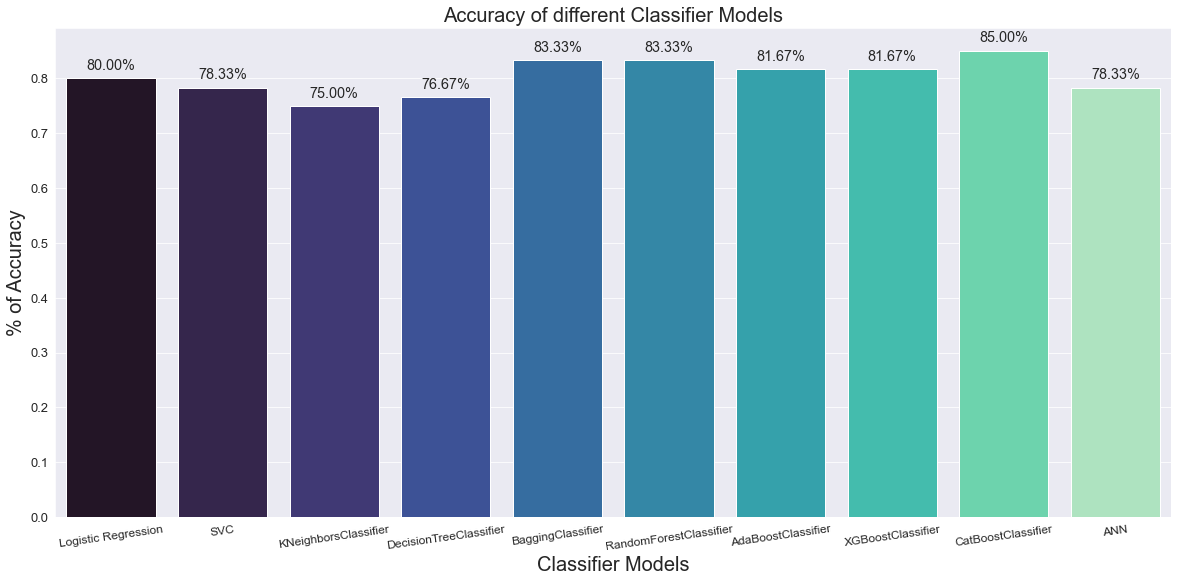

In [48]:
plt.figure(figsize=(20,9))
sns.set_style('darkgrid')
accuracy_df = pd.Series(accuracy_dict)
ax = sns.barplot(x=accuracy_df.index, y=list(accuracy_df), palette = "mako", saturation =1.5)
plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("% of Accuracy", fontsize = 20)
plt.title("Accuracy of different Classifier Models", fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

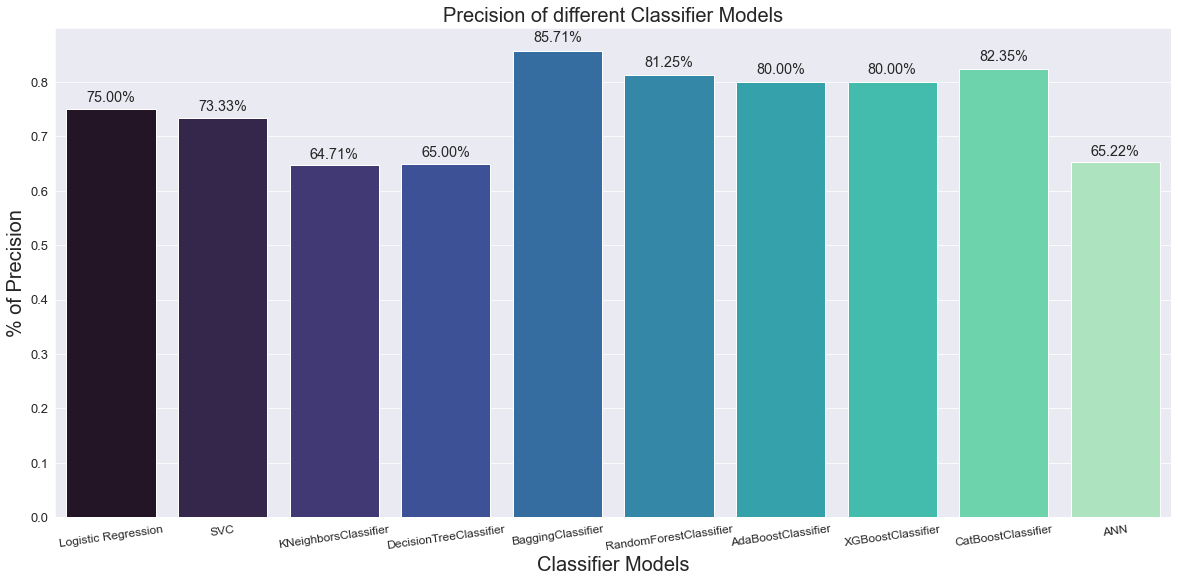

In [49]:
plt.figure(figsize=(20,9))
sns.set_style('darkgrid')
precision_df = pd.Series(precision_dict)
ax = sns.barplot(x=precision_df.index, y=list(precision_df), palette = "mako", saturation =1.5)
plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("% of Precision", fontsize = 20)
plt.title("Precision of different Classifier Models", fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

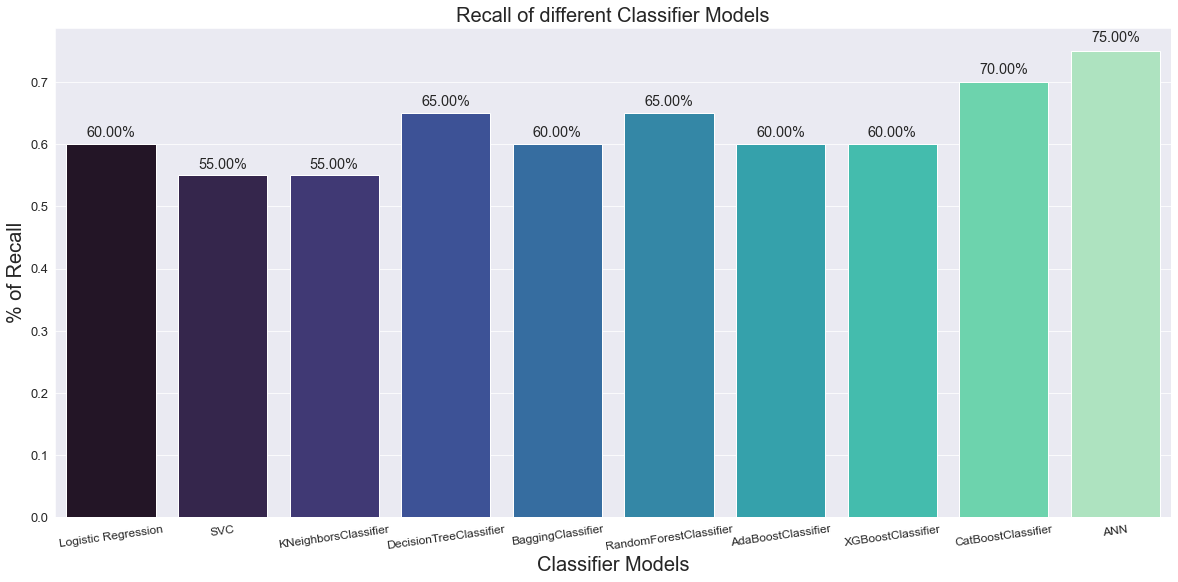

In [50]:
plt.figure(figsize=(20,9))
sns.set_style('darkgrid')
recall_df = pd.Series(recall_dict)
ax = sns.barplot(x=recall_df.index, y=list(recall_df), palette = "mako", saturation =1.5)
plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("% of Recall", fontsize = 20)
plt.title("Recall of different Classifier Models", fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

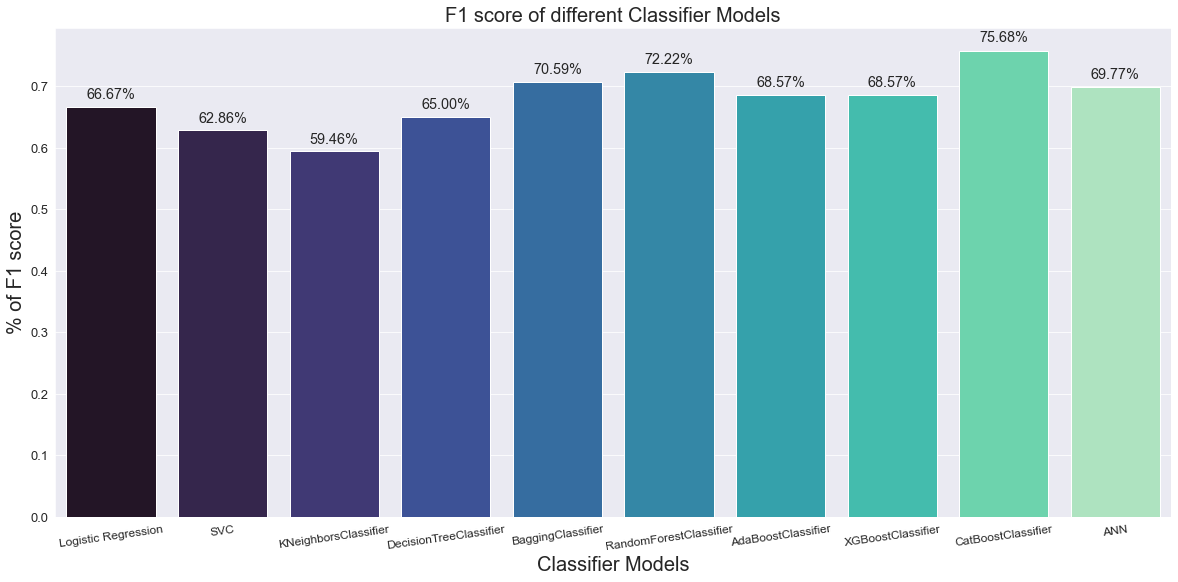

In [51]:
plt.figure(figsize=(20,9))
sns.set_style('darkgrid')
f1_df = pd.Series(f1_dict)
ax = sns.barplot(x=f1_df.index, y=list(f1_df), palette = "mako", saturation =1.5)
plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("% of F1 score", fontsize = 20)
plt.title("F1 score of different Classifier Models", fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()